## Simple diffusion on MNIST using fastai

This is an attempt to reimplement [Johno's simple diffusion notebook](https://colab.research.google.com/drive/12xmTDBYssfFVMUs0XhGXWP42SN6mijtt) using the fastai library.

**TODO:**

- [ ] sampling
- [ ] condition AE on noise amount and class

**References:**

- [Johno's original pytorch implementation of simple diffusion on MNIST](https://colab.research.google.com/drive/12xmTDBYssfFVMUs0XhGXWP42SN6mijtt)
- [Etienne's fastai VAE implementation](https://github.com/EtienneT/vae/blob/master/vae.ipynb) ([via](https://forums.fast.ai/t/fastai-v2-variational-autoencoder/85684/3?u=seem))

In [ ]:
from fastai.data.all import *
from fastai.vision.all import *
from fastprogress import progress_bar

import torch
from torch import nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Parameters
bs = 128  # batch size
lr = 5e-4 # learning rate
hidden_channels = 64

## Denoising auto-encoder on MNIST

### DataBlock: Reconstructing noisy MNIST images

In [ ]:
# TODO: is there a better way to apply noise to only the input image than dispatching on a new type?
class PILImageBWNoised(PILImageBW): pass
class TensorImageBWNoised(TensorImageBW):
    def show(self, ctx=None, **kwargs):
        super().show(ctx=ctx, **kwargs)
        # TODO: how do we include the noise amount as the title?
        # ctx.set_title(f'Noise amount: {amount}')
PILImageBWNoised._tensor_cls = TensorImageBWNoised

In [ ]:
class AddNoise(Transform):
    def encodes(self, x:TensorImageBWNoised):
        x = IntToFloatTensor()(x) # TODO: why doesn't it work if I put this in batch_tfms?
        amount = torch.rand(x.shape[0], device=x.device)
        noise = torch.rand_like(x, device=x.device)
        return torch.lerp(x, noise, amount.view(-1, 1, 1, 1)) * 255

In [ ]:
path = untar_data(URLs.MNIST)
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBWNoised),ImageBlock(cls=PILImageBW)),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter('training', 'testing'),
                   batch_tfms=[AddNoise])
dls = dblock.dataloaders(path, bs=bs)

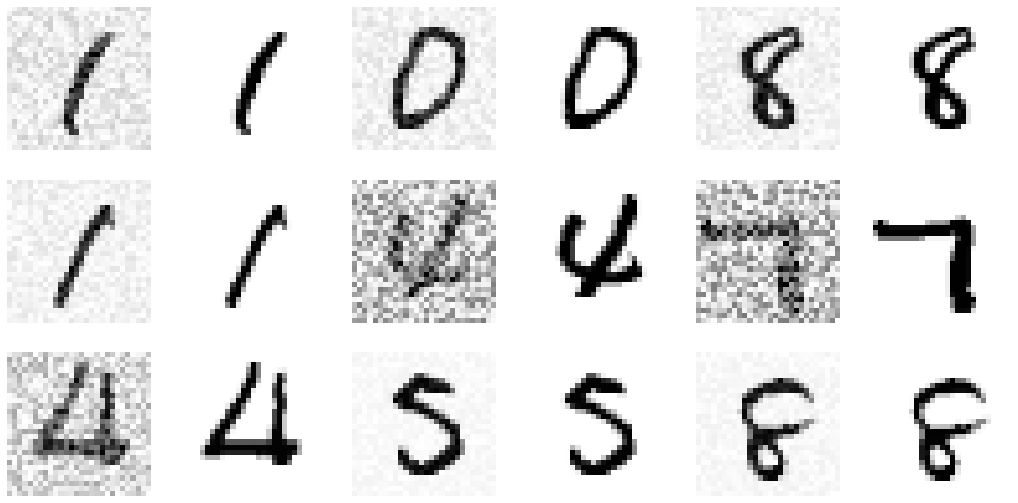

In [ ]:
dls.show_batch()

### Model: Basic convolutional auto-encoder

In [ ]:
class BasicConvNet(Module):
    def __init__(self, in_channels=1, out_channels=1, kernel_size=5, hidden_channels=32, n_layers=4):
        super().__init__()
        padding = kernel_size // 2 # So we keep output size the same
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size,  padding=padding),
            nn.ReLU(),
            *[nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=padding),
            nn.ReLU()]*n_layers, # n_layers duplicates of this
            nn.Conv2d(hidden_channels, out_channels, kernel_size, padding=padding))
    def forward(self, x): return self.net(x)

In [ ]:
ims,_ = dls.one_batch()
im = ims[0]

In [ ]:
model = BasicConvNet().cuda()
test_eq(im.shape, model(im).shape)

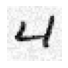

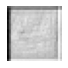

In [ ]:
im.show()
model(im).show();

### Learner

In [ ]:
model = BasicConvNet(hidden_channels=hidden_channels).cuda()
learn = Learner(dls, model, loss_func=MSELossFlat(), lr=lr)

For comparison, the original simple diffusion notebook achieves ~0.02 after one epoch. I'm not 100% sure if these are directly comparable, but have tried to use the same hyperparameters.

In [ ]:
learn.fit(1)

epoch,train_loss,valid_loss,time
0,0.020287,0.019272,00:40


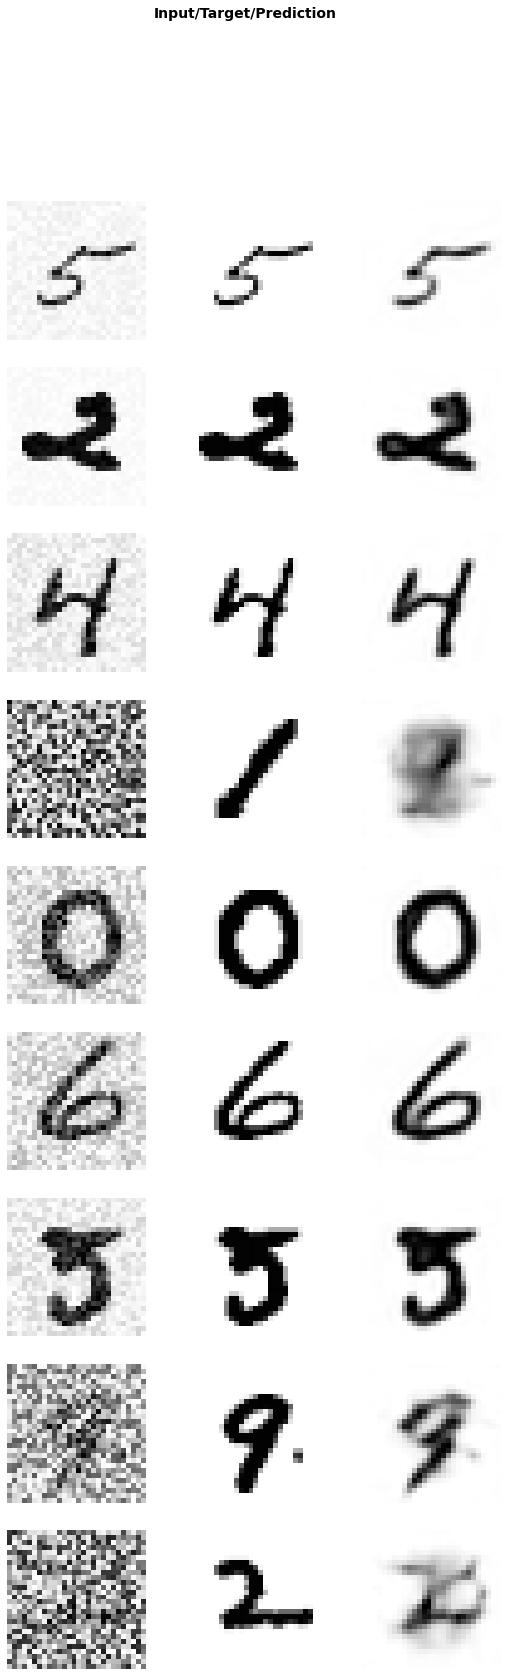

In [ ]:
learn.show_results()